# Imports

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import functools
import collections
import glob
import itertools
import multiprocessing
import pickle
import re
import os
import sys
import json
from ast import literal_eval

import numpy as onp
import pandas as pd
import plotnine as gg
from ray.tune import Analysis
# import jax.numpy as jnp
# import jax
# import tree

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, '../')

from common.notebook_utils import (
    load_data,
    get_ckpt_paths,
    seed_mavg,
    parse_str_col,
    explode,
    softplus,
)

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Monitoring

In [139]:
experiment_dirs = [
    '~/ray_results/simple_maze_5:trunc_8_16_32:flip_interval_6400:no_reset_theta:inner_lr_1:vf_coef_01:ibs_5:obs_50:sweep_lr_1em6_5em6',
    '~/ray_results/simple_maze_5:trunc_64:flip_interval_6400:no_reset_theta:inner_lr_1:vf_coef_01:ibs_5:obs_50:sweep_lr_1em6_5em6',
]
DF, HYPERS = load_data(experiment_dirs)

es_experiment_dirs = [
    '~/ray_results/simple_maze_5:flip_interval_6400:no_reset_theta:es:openes:ilr_1:trunc_8_16_32_64:olr_sweep',
    '~/ray_results/simple_maze_5:flip_interval_6400:no_reset_theta:es:openes:ilr_1:trunc_200_400_4',
]
ES_DF, HYPERS = load_data(es_experiment_dirs)



In [140]:
df = ES_DF
label_cols = {
    'HYPER_outer_loss': 'outer loss',
    'HYPER_es_params_lrate_init': 'learning rate',
    'HYPER_es_params_beta_1': 'beta 1',
}
def labeler(row):
    label = '\n'.join([f'{label} {row[col]}' for col, label in label_cols.items()])
    return label
df['raw_label'] = df.apply(labeler, axis=1)
df_ = df

df_['label'] = pd.Categorical(
    df_.raw_label,
    df_.drop_duplicates('raw_label').sort_values(list(label_cols.keys())).raw_label
)

In [141]:
full_df = DF
es_df = ES_DF

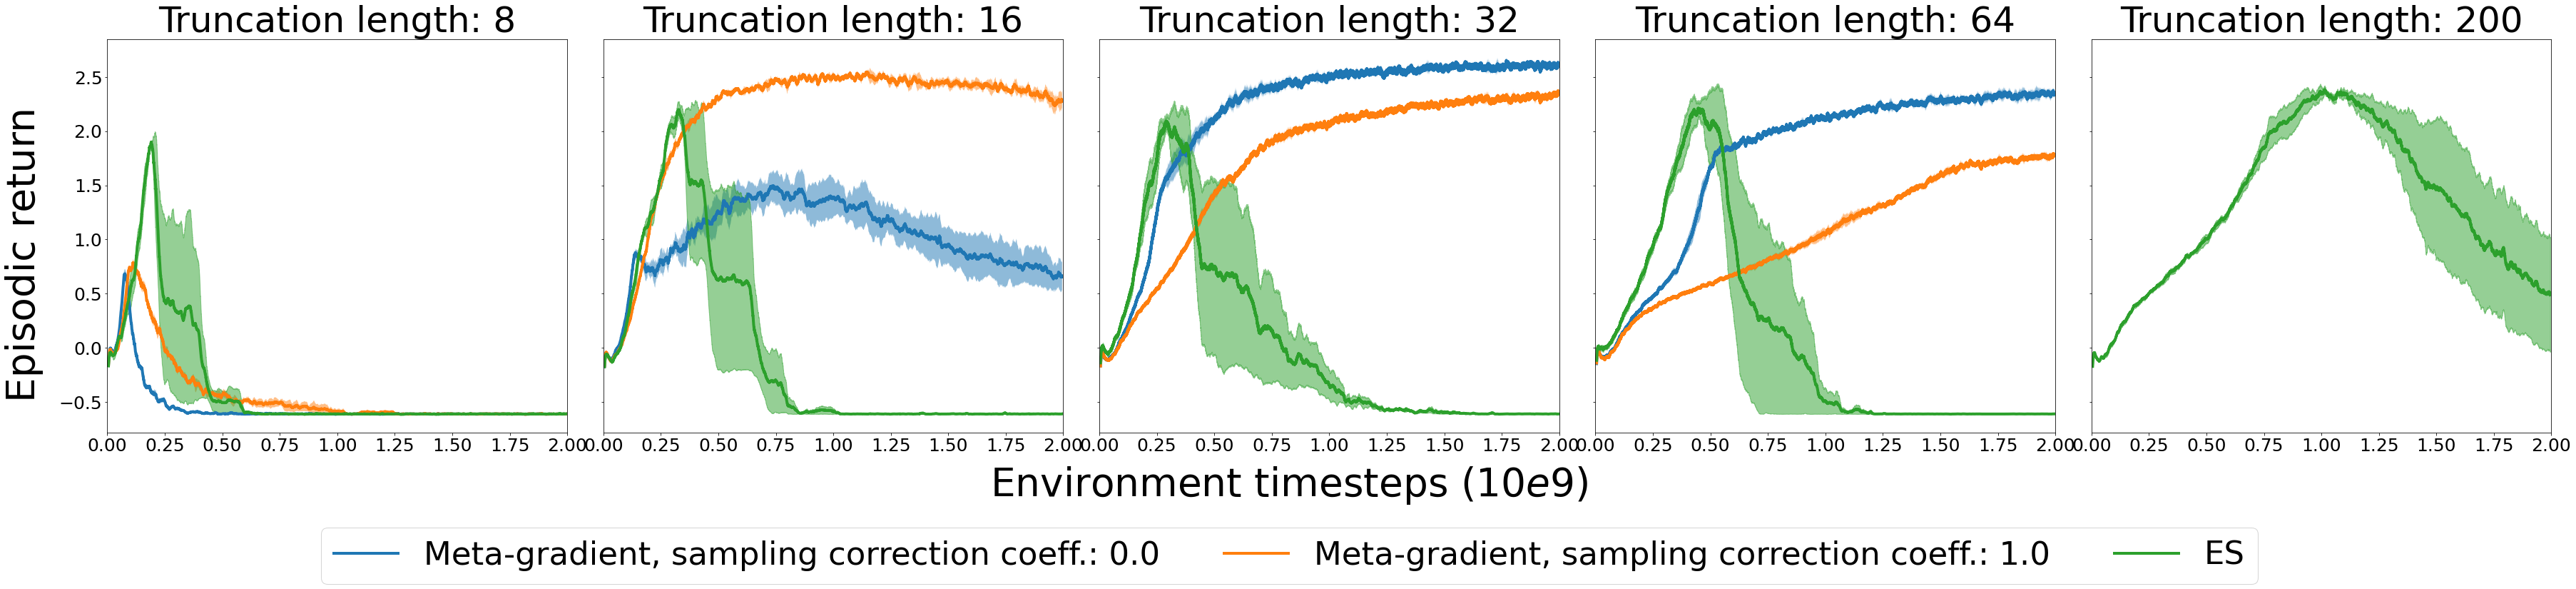

In [142]:
LEGEND_TITLE_FONTSIZE = 35
LEGEND_FONTSIZE = 25
AXIS_LABEL_SIZE = 55
TICK_SIZE = 30

variants = [
    (0.0, 8, 1e-6),
    (1.0, 8, 1e-6),
    # (0.0, 8, 5e-6),
    # (1.0, 8, 5e-6),
    (0.0, 16, 1e-6),
    # (1.0, 16, 1e-6),
    # (0.0, 16, 5e-6),
    (1.0, 16, 5e-6),
    # (0.0, 32, 1e-6),
    # (1.0, 32, 1e-6),
    (0.0, 32, 5e-6),
    (1.0, 32, 5e-6),
    # (0.0, 32, 1e-6),
    # (1.0, 32, 1e-6),
    (0.0, 64, 5e-6),
    (1.0, 64, 5e-6),
]
variants_for_truncs = {
    8: [(0.0, 5e-6), (1.0, 5e-6)],
    16: [(0.0, 5e-6), (1.0, 5e-6)],
    32: [(0.0, 5e-6), (1.0, 5e-6)],
    64: [(0.0, 5e-6), (1.0, 5e-6)],
    200: [],
}

es_variants_for_truncs = {
    8: [(1e-6)],
    16: [(1e-6)],
    32: [(1e-6)],
    64: [(1e-6)],
    200: [(1e-6)],
}
fig, axes = plt.subplots(1, 5, figsize=(50, 10), sharey=True)
axes = onp.array(axes)
full_df['ep_reward'] = full_df['reward_per_timestep'] * 16.0
full_df['small_steps'] = full_df['total_steps'] / 10e9
es_df['ep_reward'] = es_df['reward_per_timestep'] * 16.0
es_df['small_steps'] = es_df['total_steps'] / 10e9
for trunc, ax in zip([8, 16, 32, 64, 200], axes):
    for ml, lr in variants_for_truncs[trunc]:
        all_data = full_df[
            True
            & (full_df.HYPER_meta_lambda == ml)
            & (full_df.HYPER_truncation_length == trunc)
            & (full_df.HYPER_opt_kwargs_learning_rate == lr)
        ]
        data = all_data.reset_index()
        window = 100
        smoothed = data.groupby(['HYPER_seed']).rolling(window).mean().groupby('index')
        y = smoothed.mean()['ep_reward'].to_numpy()
        stderr = (smoothed.std()['ep_reward'].fillna(0.).to_numpy()
                    / onp.sqrt(len(data.HYPER_seed.unique())))
        x = smoothed.min().small_steps
        out = pd.DataFrame({'x': x, 'y': y})
        out.reset_index(inplace=True, drop=True)

        out = pd.DataFrame({'x': x, 'y': y})
        out.reset_index(inplace=True, drop=True)
        label = f"Meta-gradient, sampling correction coeff.: {ml}"
        ax.plot(
            out.x, out.y,
            linewidth=4.0,
            label=label,
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
        )
    ax.set_title(f'Truncation length: {trunc}', fontsize=AXIS_LABEL_SIZE - 5)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE - 5)
    ax.set_xlim([0, 2.0])
    for lr in es_variants_for_truncs[trunc]:
        all_data = es_df[
            True
            & (es_df.HYPER_truncation_length == trunc)
            & (es_df.HYPER_es_params_lrate_init == lr)
        ]
        data = all_data.reset_index()
        window = 100
        smoothed = data.groupby(['HYPER_seed']).rolling(window).mean().groupby('index')
        y = smoothed.mean()['ep_reward'].to_numpy()
        stderr = (smoothed.std()['ep_reward'].fillna(0.).to_numpy()
                    / onp.sqrt(len(data.HYPER_seed.unique())))
        x = smoothed.min().small_steps
        out = pd.DataFrame({'x': x, 'y': y})
        out.reset_index(inplace=True, drop=True)

        out = pd.DataFrame({'x': x, 'y': y})
        out.reset_index(inplace=True, drop=True)
        label = f"ES"
        ax.plot(
            out.x, out.y,
            linewidth=4.0,
            label=label,
            color='#2ca02c',
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color='#2ca02c',
        )

handles, _ = axes[0].get_legend_handles_labels()
fig.legend(
#     title="Sampling\ncorrection\ncoefficient",
    fontsize=LEGEND_FONTSIZE + 20,
    title_fontsize=LEGEND_TITLE_FONTSIZE,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.0),
#     fancybox=True,
#     shadow=True,
    handles=handles,
    ncol=3,
)

fig.supxlabel('Environment timesteps ($10e9$)', fontsize=AXIS_LABEL_SIZE)
fig.supylabel('Episodic return', fontsize=AXIS_LABEL_SIZE, x=0.0)
plt.tight_layout()
plt.savefig(f'images/gridworld_learning_curves.pdf', bbox_inches='tight')



# Evaluation

In [111]:
experiment_dirs = [
    '~/ray_results/evaluate:simple_maze_5:trunc_8_16_32:flip_interval_6400:reset_theta:inner_lr_1:vf_coef_01:ibs_5:obs_50:sweep_lr_1em6_5em6',
    '~/ray_results/evaluate:simple_maze_5:trunc_64:flip_interval_6400:reset_theta:inner_lr_1:vf_coef_01:ibs_5:obs_50:sweep_lr_1em6_5em6',
]

DF, HYPERS = load_data(experiment_dirs)

In [112]:
df = DF
label_cols = {
    'HYPER_opt_kwargs_learning_rate': 'Learning rate',
    'HYPER_truncation_length': 'Truncation length',
    'HYPER_meta_lambda': 'Sampling correction coefficient',
    # 'HYPER_checkpoint_path': 'ckpt',
}
def labeler(row):
    label = '\n'.join([f'{label} {row[col]}' for col, label in label_cols.items()])
    return label
df['raw_label'] = df.apply(labeler, axis=1)
df_ = df
df_['label'] = pd.Categorical(
    df_.raw_label,
    df_.drop_duplicates('raw_label').sort_values(list(label_cols.keys())).raw_label
)


In [113]:
eval_df = df

In [114]:
variants = df.groupby(list(label_cols.keys())).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

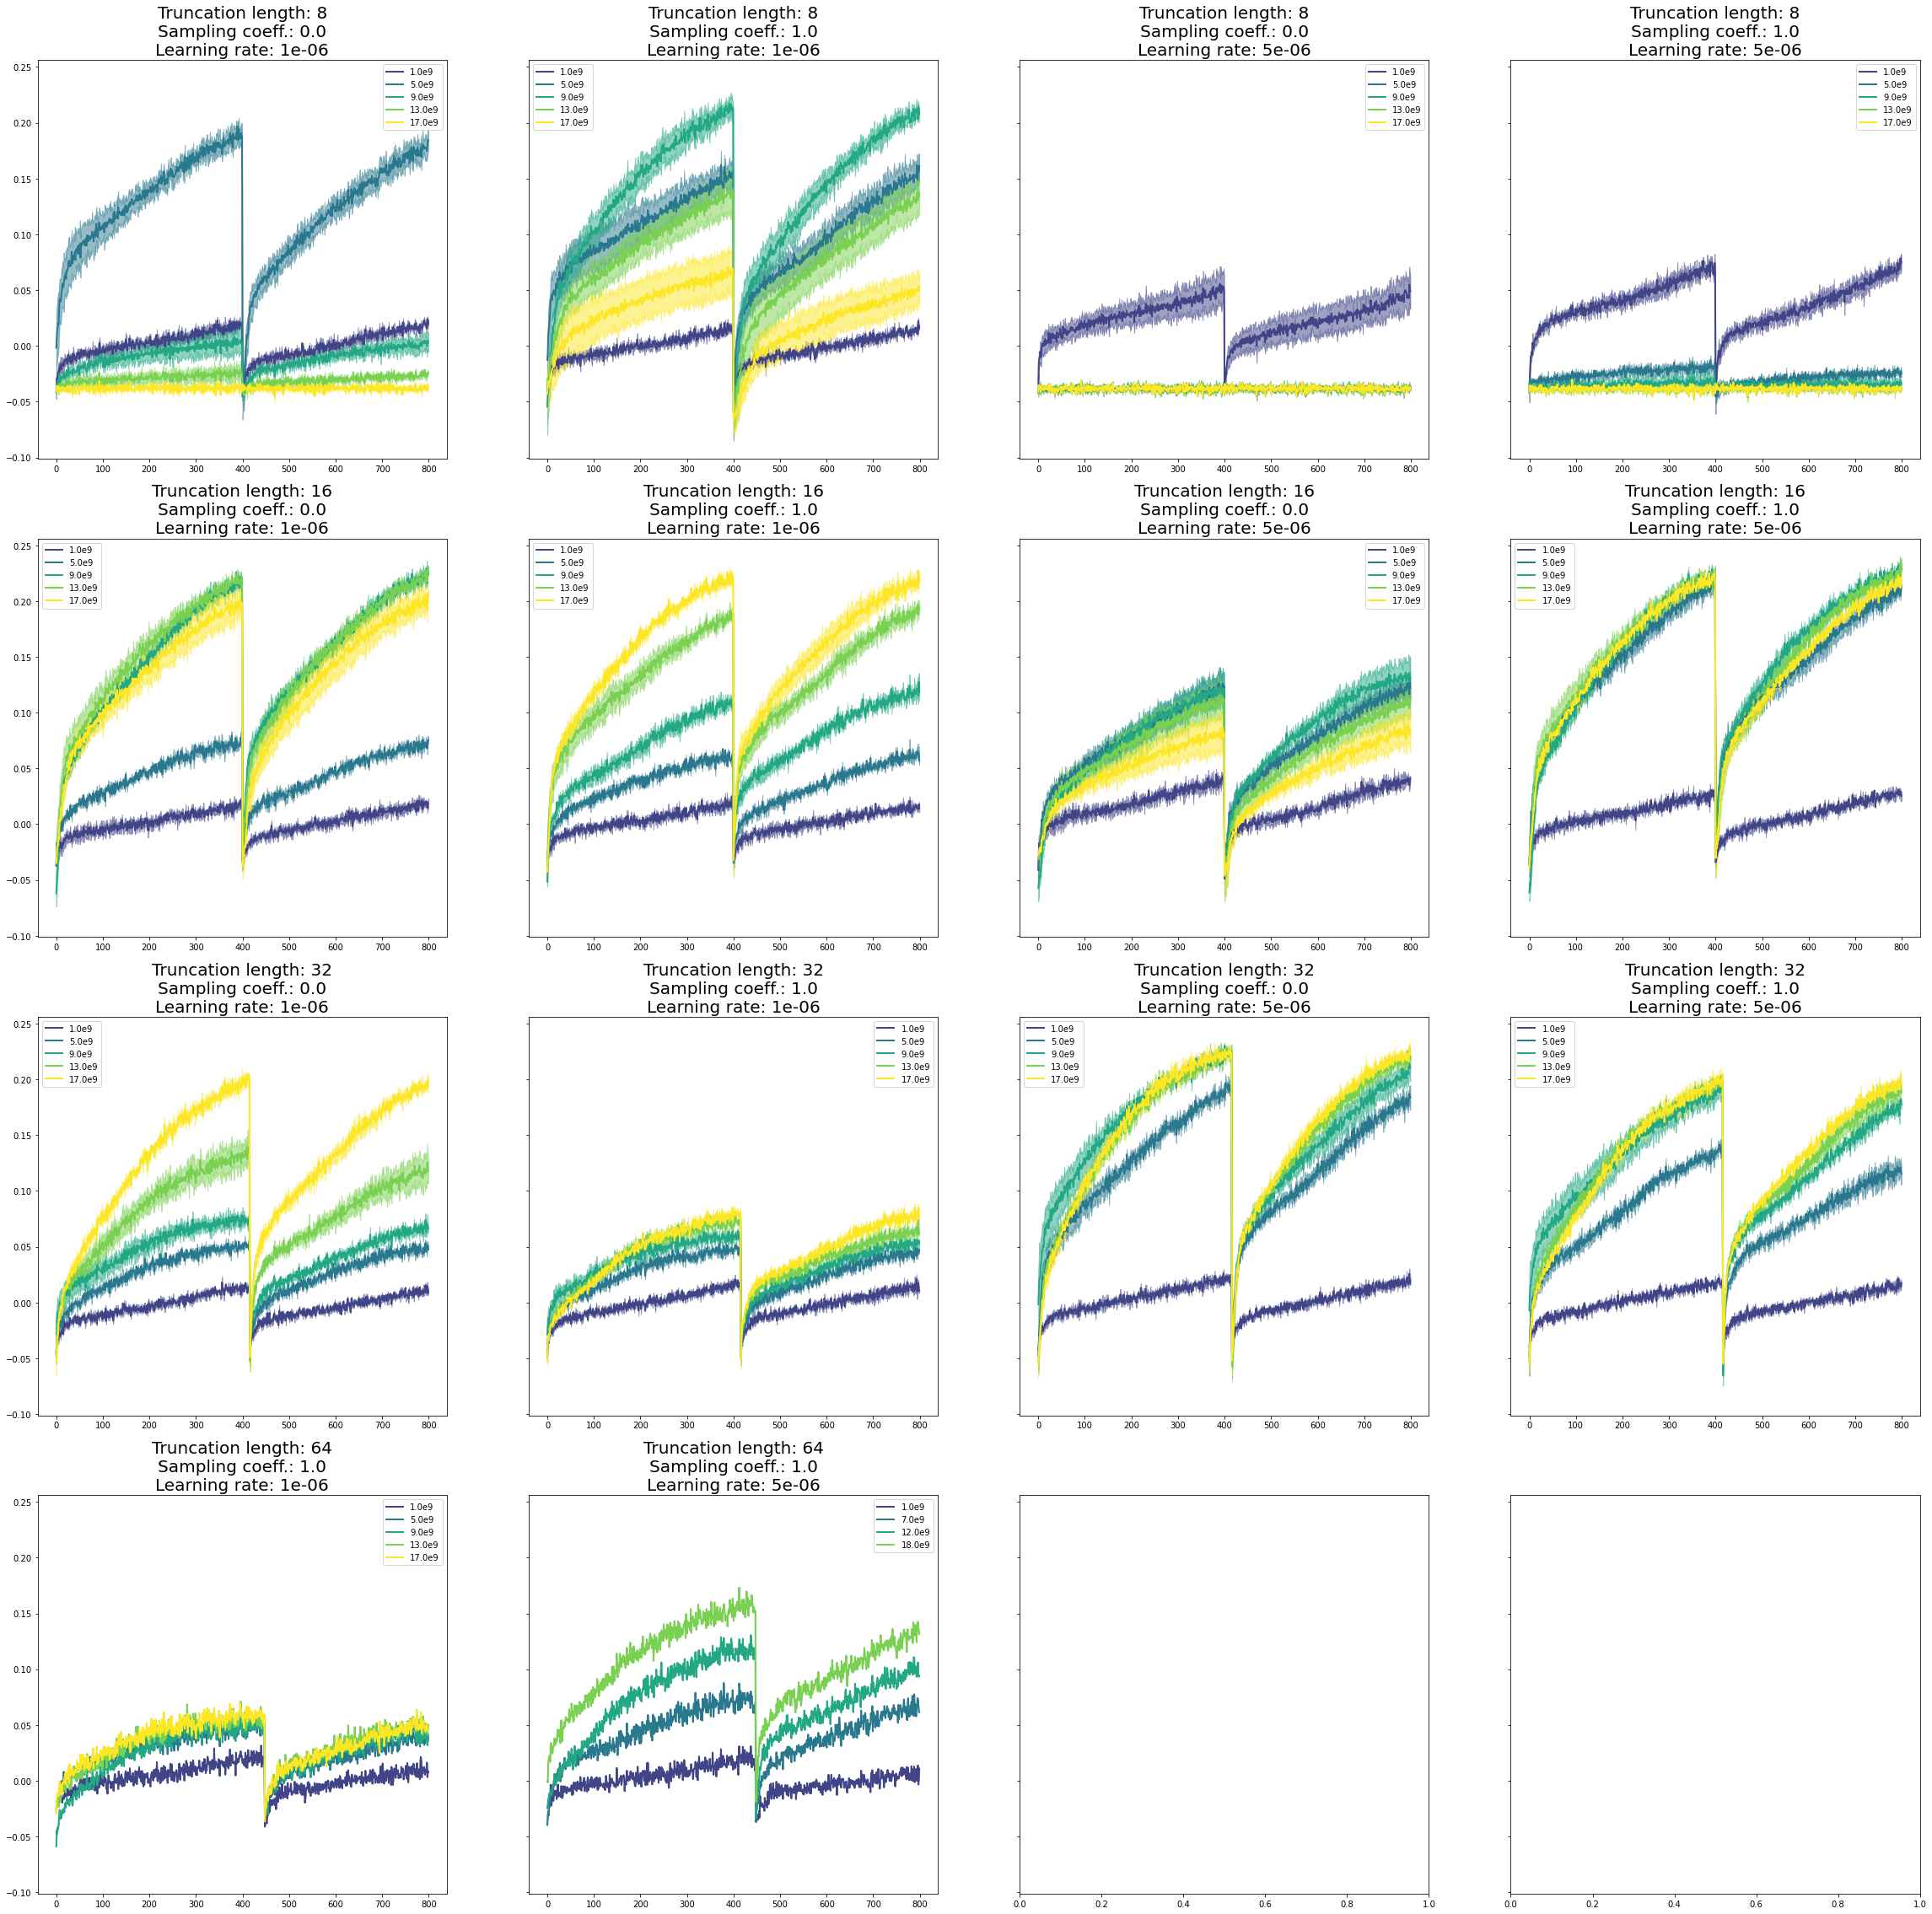

In [115]:
variants = eval_df.groupby(list(label_cols.keys())).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

sideX = 4
sideY = 4
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1

axes = axes.flatten()
for ax, row in zip(axes, variants.sort_values('HYPER_truncation_length').itertuples(index=False)):
    f = True
    for k, v in row._asdict().items():
        f = f & (eval_df[k] == v)
    
    eval_data = eval_df[f]
    ckpts = eval_data.HYPER_checkpoint_path.unique()
    ckpt_to_numeric = lambda x: int(re.findall(r'checkpoint\_([0-9]*)\.ckpt', x)[0])
    numeric_ckpts = list(map(ckpt_to_numeric, ckpts))
    ckpt_map = collections.defaultdict(list)
    for ckpt_no, ckpt in zip(numeric_ckpts, ckpts):
        ckpt_map[ckpt_no].append(ckpt)
    sorted_ckpt_nos = sorted(set(numeric_ckpts))
    chosen_ckpt_nos = sorted_ckpt_nos[::4]


    for i, ckpt_no in enumerate(chosen_ckpt_nos):
        ff = f & (df.HYPER_checkpoint_path.isin(ckpt_map[ckpt_no]))
        data = df[ff].reset_index()
    
        if len(data) == 0:
            continue

        smoothed = data.groupby('index')
        y = smoothed.mean()['reward_per_timestep'].to_numpy()
        stderr = (smoothed.std()['reward_per_timestep'].fillna(0.).to_numpy()
                    / onp.sqrt(len(eval_data.HYPER_seed.unique())))[:800]
        x = smoothed.mean().index
        out = pd.DataFrame({'x': x[:800], 'y': y[:800]})
        out.reset_index(inplace=True, drop=True)
        ax.plot(
            out.x, out.y,
            linewidth=2.0,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
            label=f'{onp.ceil(ckpt_no / 1e9)}e9'
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
        )
        params = row._asdict()
        title = f"Truncation length: {params['HYPER_truncation_length']}\n" \
                f"Sampling coeff.: {params['HYPER_meta_lambda']}\n" \
                f"Learning rate: {params['HYPER_opt_kwargs_learning_rate']}"
        # ax.set_title('\n'.join(f"{label_cols[k]}: {v}" for k, v in row._asdict().items()), fontsize=20)
        ax.set_title(title, fontsize=20)
        ax.legend()


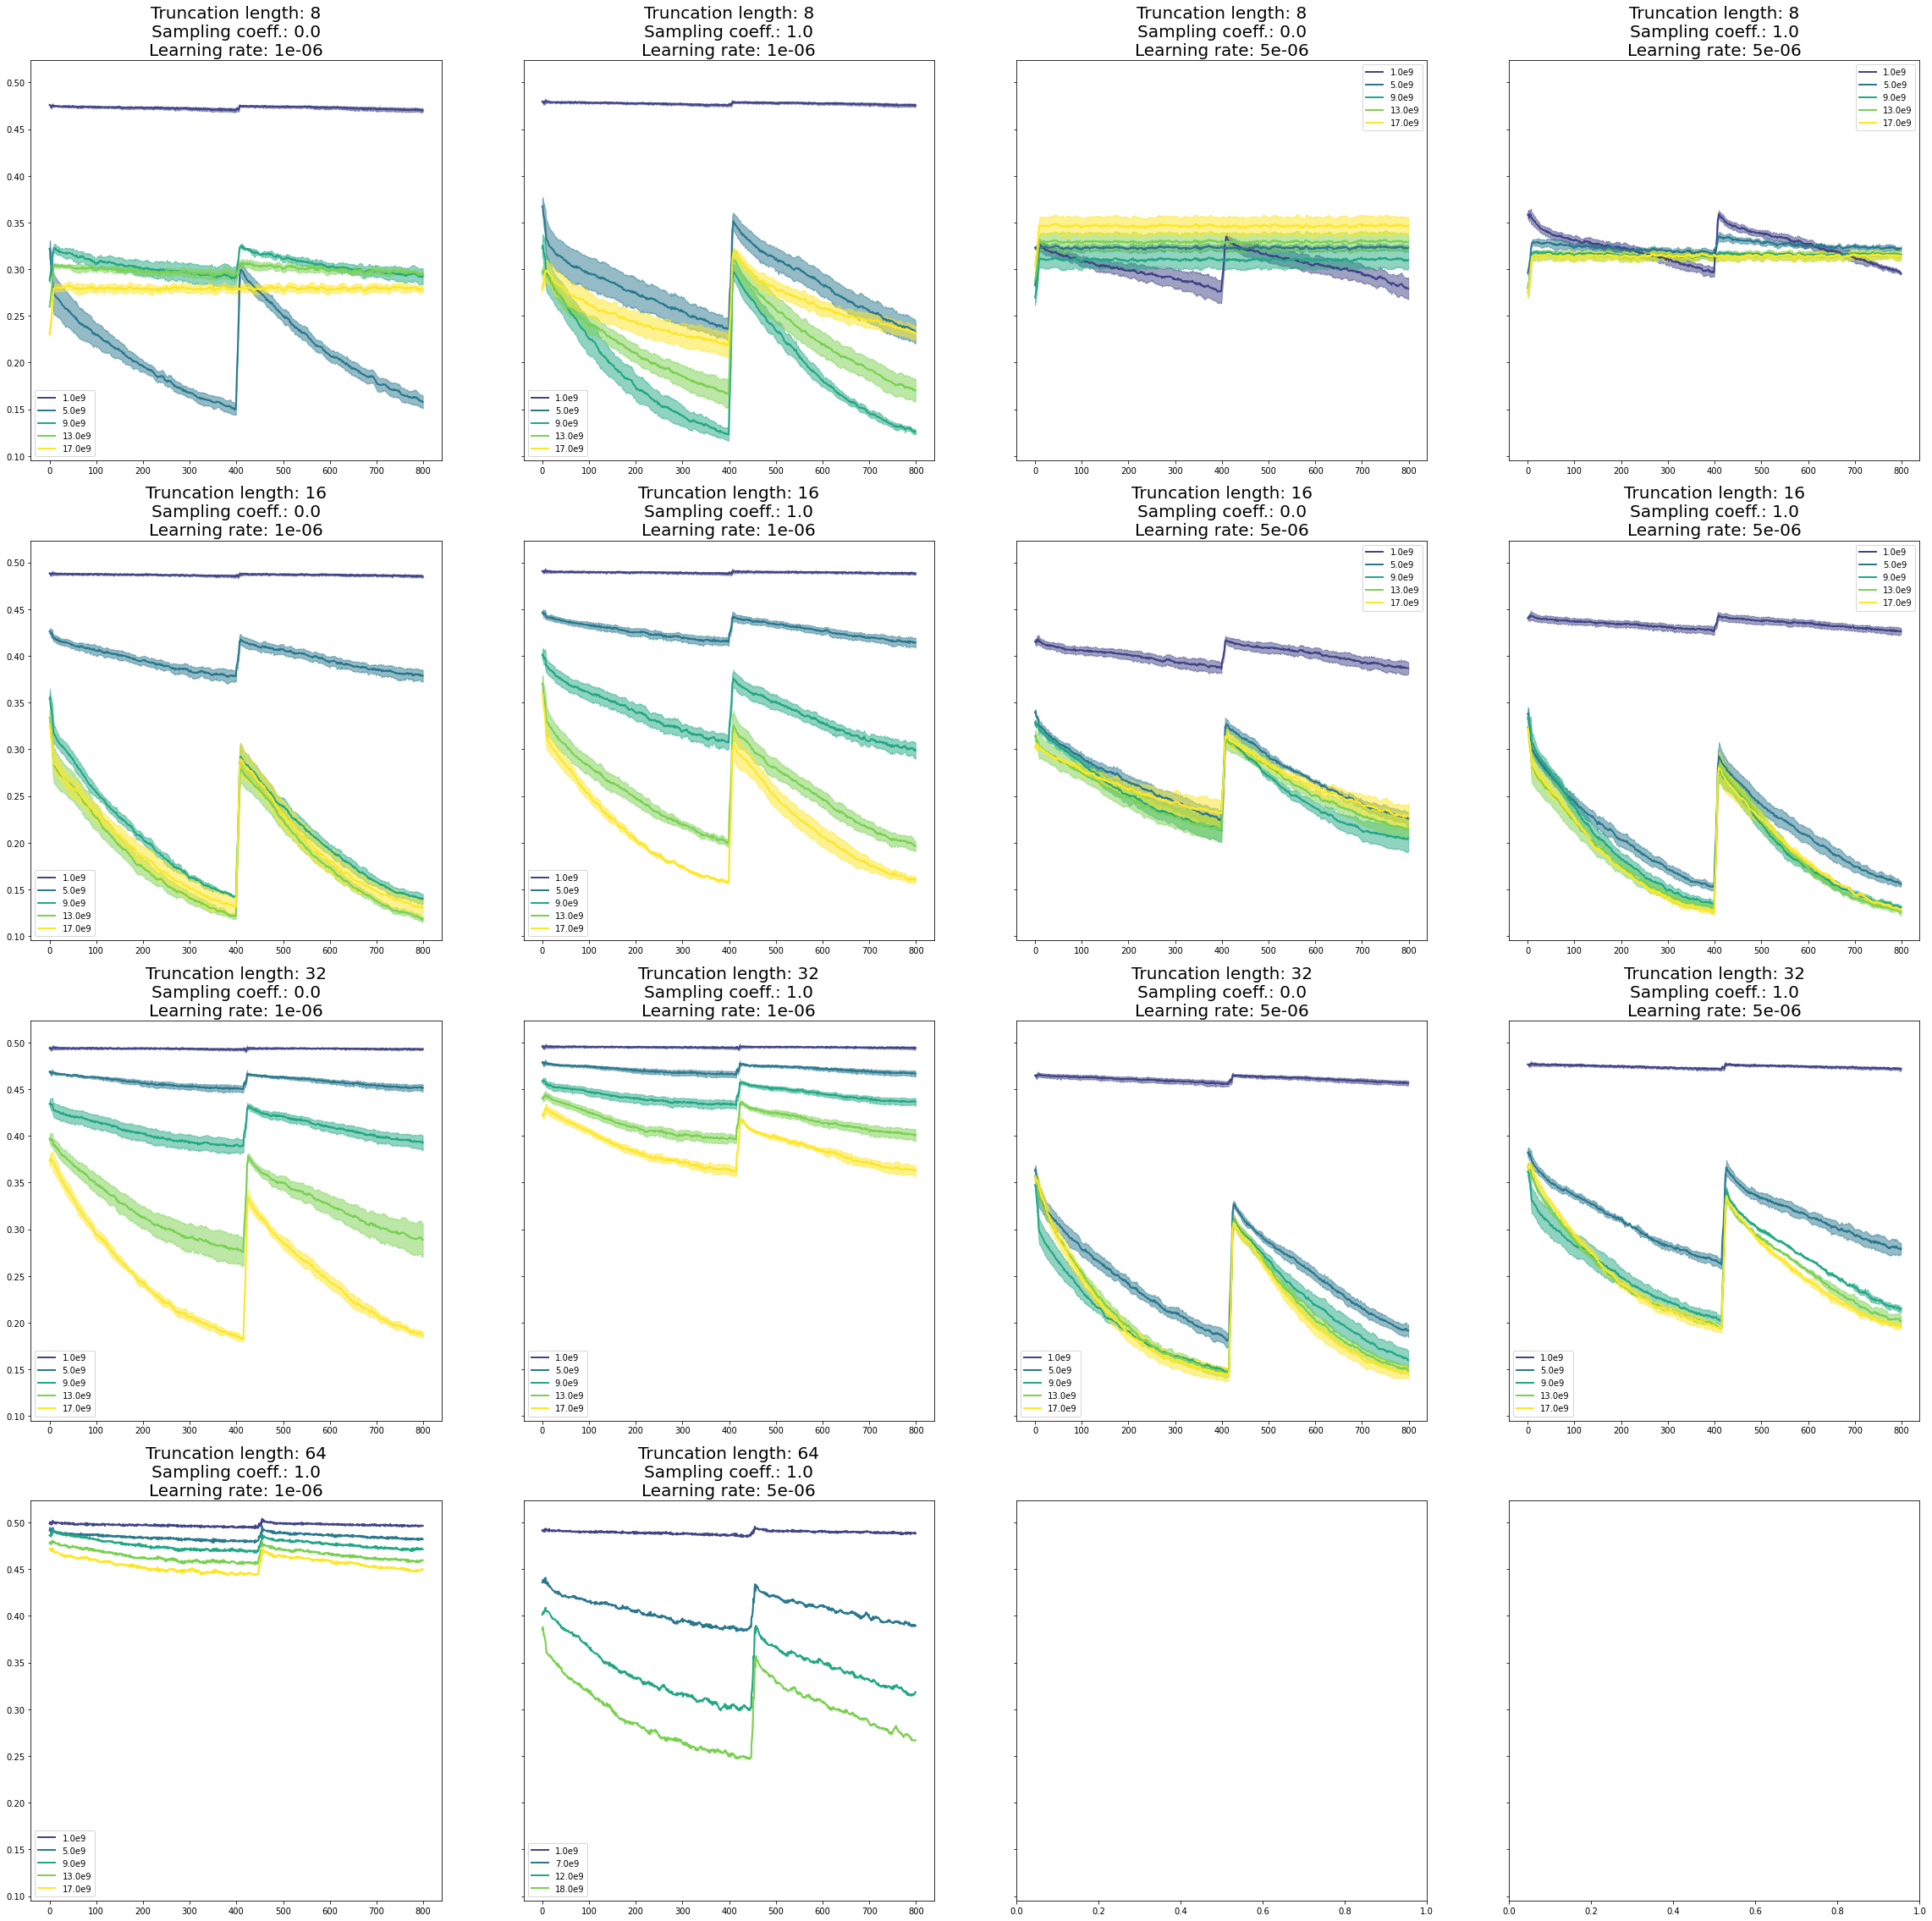

In [116]:
variants = eval_df.groupby(list(label_cols.keys())).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

sideX = 4
sideY = 4
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1

axes = axes.flatten()
for ax, row in zip(axes, variants.sort_values('HYPER_truncation_length').itertuples(index=False)):
    f = True
    for k, v in row._asdict().items():
        f = f & (eval_df[k] == v)
    
    eval_data = eval_df[f]
    ckpts = eval_data.HYPER_checkpoint_path.unique()
    ckpt_to_numeric = lambda x: int(re.findall(r'checkpoint\_([0-9]*)\.ckpt', x)[0])
    numeric_ckpts = list(map(ckpt_to_numeric, ckpts))
    ckpt_map = collections.defaultdict(list)
    for ckpt_no, ckpt in zip(numeric_ckpts, ckpts):
        ckpt_map[ckpt_no].append(ckpt)
    sorted_ckpt_nos = sorted(set(numeric_ckpts))
    chosen_ckpt_nos = sorted_ckpt_nos[::4]


    for i, ckpt_no in enumerate(chosen_ckpt_nos):
        ff = f & (df.HYPER_checkpoint_path.isin(ckpt_map[ckpt_no]))
        data = df[ff].reset_index()
    
        if len(data) == 0:
            continue

        smoothed = data.groupby('index')
        y = smoothed.mean()['ent_coef'].to_numpy()
        stderr = (smoothed.std()['ent_coef'].fillna(0.).to_numpy()
                    / onp.sqrt(len(eval_data.HYPER_seed.unique())))[:800]
        x = smoothed.mean().index
        out = pd.DataFrame({'x': x[:800], 'y': y[:800]})
        out.reset_index(inplace=True, drop=True)
        ax.plot(
            out.x, out.y,
            linewidth=2.0,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
            label=f'{onp.ceil(ckpt_no / 1e9)}e9'
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
        )
        params = row._asdict()
        title = f"Truncation length: {params['HYPER_truncation_length']}\n" \
                f"Sampling coeff.: {params['HYPER_meta_lambda']}\n" \
                f"Learning rate: {params['HYPER_opt_kwargs_learning_rate']}"
        # ax.set_title('\n'.join(f"{label_cols[k]}: {v}" for k, v in row._asdict().items()), fontsize=20)
        ax.set_title(title, fontsize=20)
        ax.legend()


# ES evaluation

In [121]:
experiment_dirs = [
    '/ray_results/evaluate:simple_maze_5:flip_interval_6400:no_reset_theta:es:openes:ilr_1:trunc_8_16_32_64:olr_sweep',
]

DF, HYPERS = load_data(experiment_dirs)

In [122]:
df = DF
label_cols = {
    'HYPER_es_params_lrate_init': 'Learning rate',
    'HYPER_truncation_length': 'Truncation length',
#     'HYPER_meta_lambda': 'Sampling correction coefficient',
    # 'HYPER_checkpoint_path': 'ckpt',
#     'HYPER_es_params_lrate_init': 'learning rate',
}
def labeler(row):
    label = '\n'.join([f'{label} {row[col]}' for col, label in label_cols.items()])
    return label
df['raw_label'] = df.apply(labeler, axis=1)
df_ = df
df_['label'] = pd.Categorical(
    df_.raw_label,
    df_.drop_duplicates('raw_label').sort_values(list(label_cols.keys())).raw_label
)


In [123]:
eval_df = df

In [124]:
variants = df.groupby(list(label_cols.keys())).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

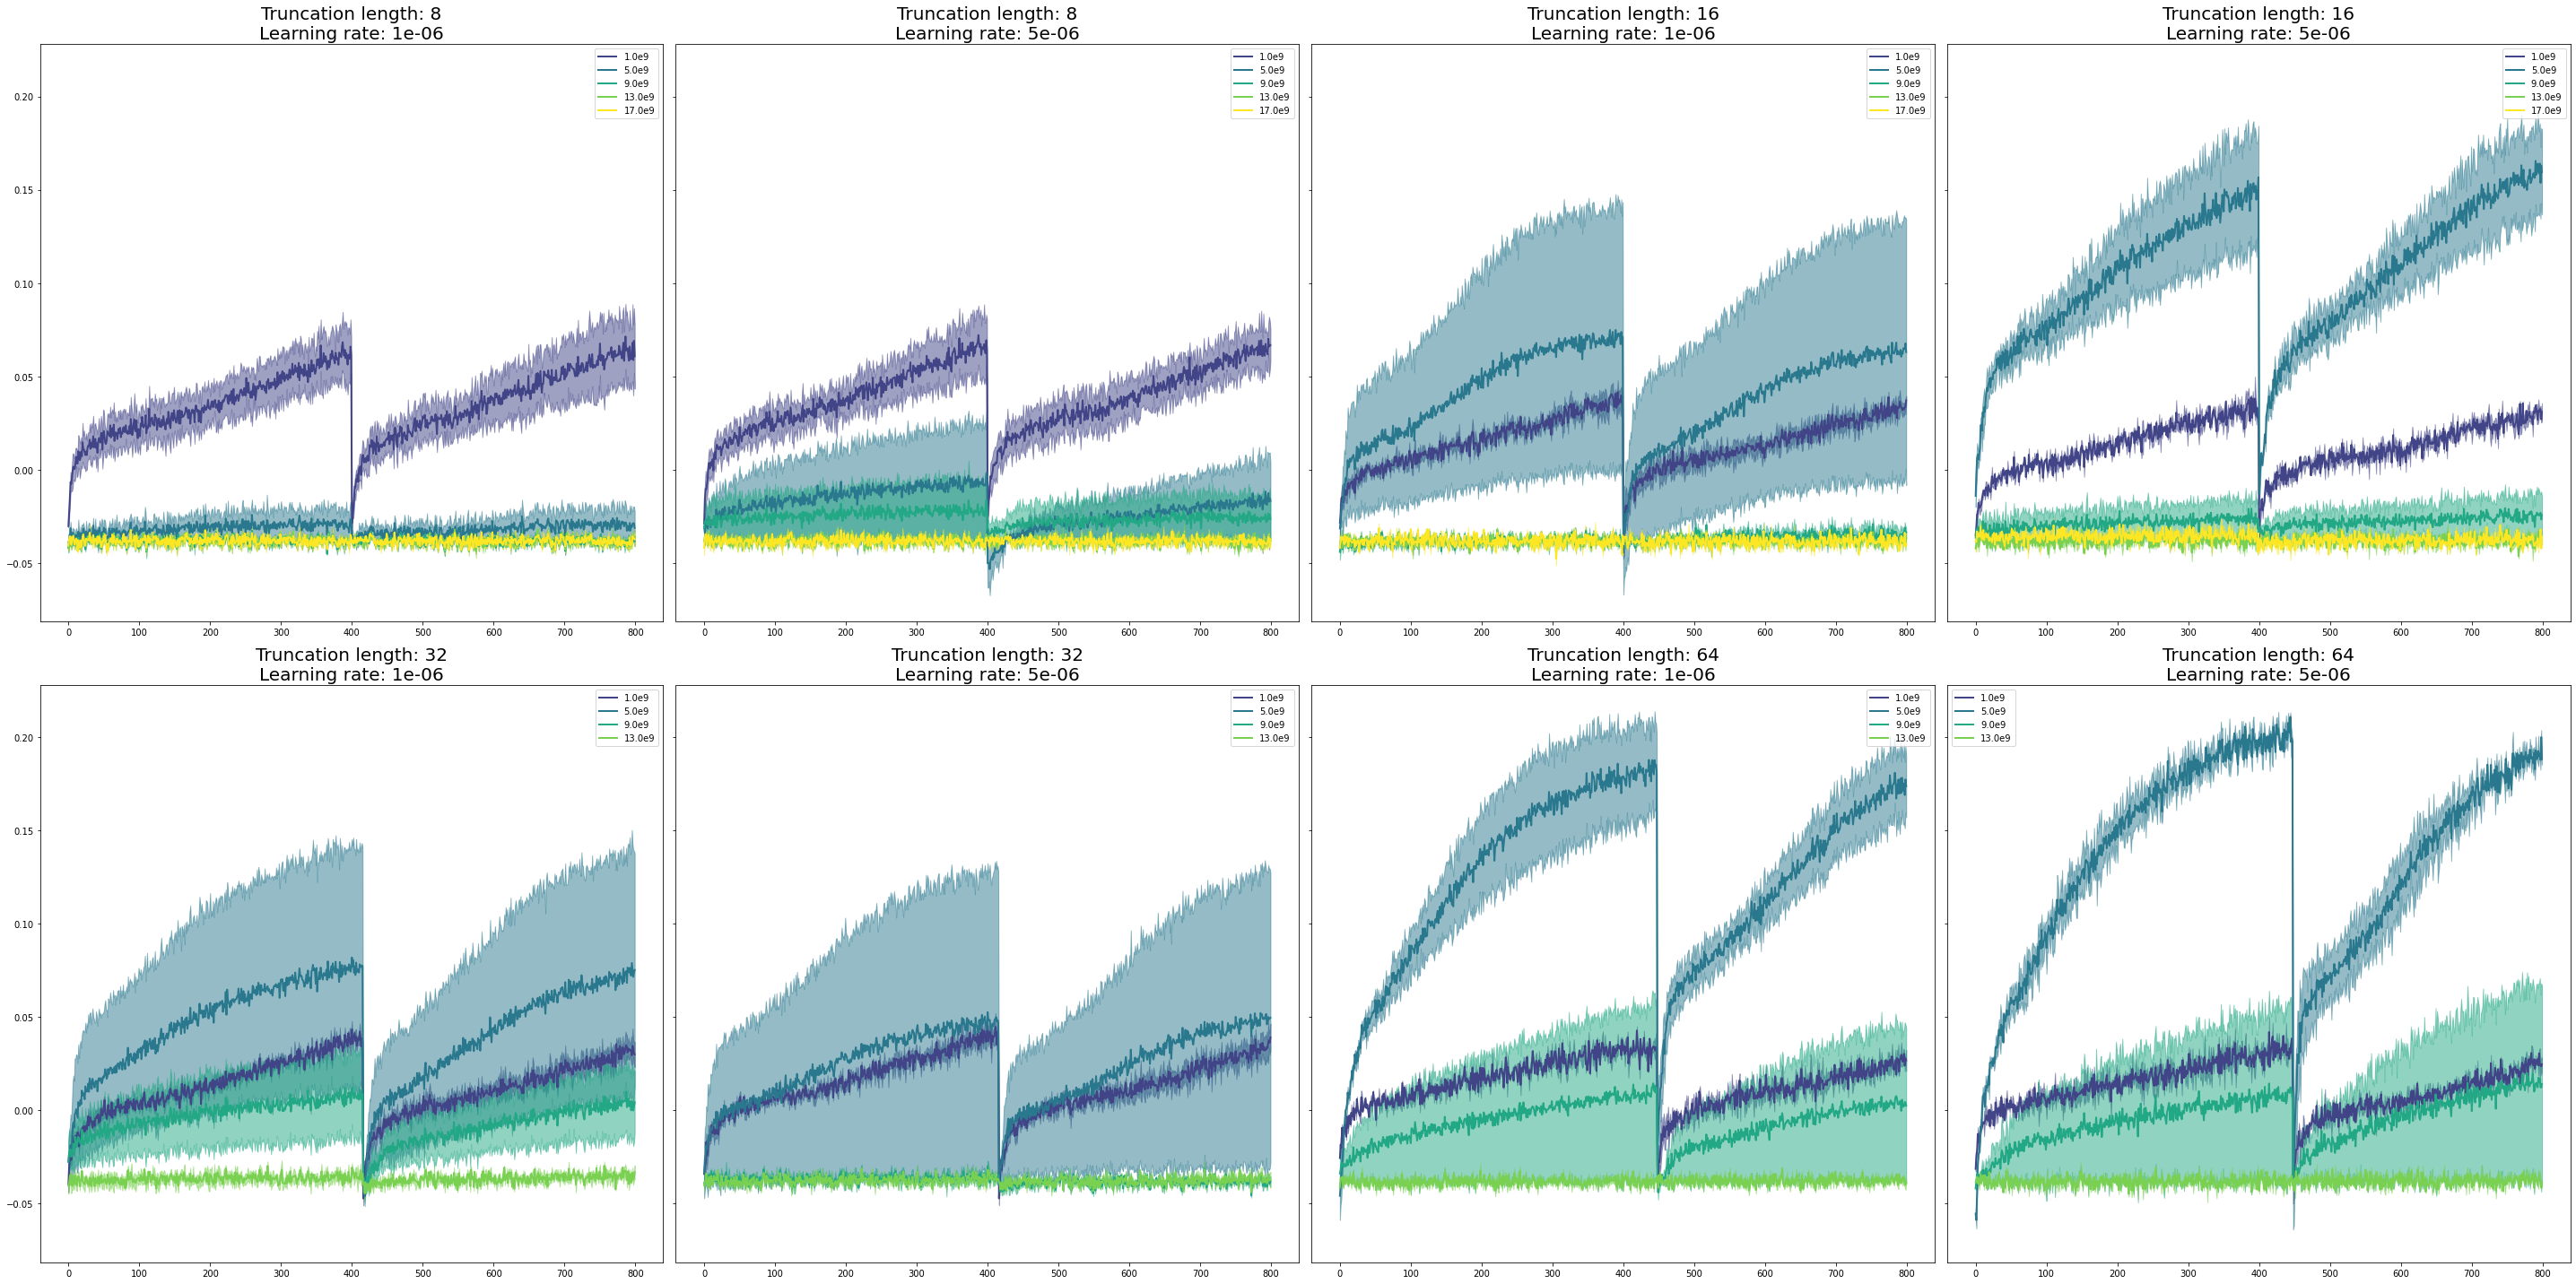

In [130]:
variants = eval_df.groupby(list(label_cols.keys())).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

sideX = 4
sideY = 2
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1

axes = axes.flatten()
for ax, row in zip(axes, variants.sort_values('HYPER_truncation_length').itertuples(index=False)):
    f = True
    for k, v in row._asdict().items():
        f = f & (eval_df[k] == v)
    
    eval_data = eval_df[f]
    ckpts = eval_data.HYPER_checkpoint_path.unique()
    ckpt_to_numeric = lambda x: int(re.findall(r'checkpoint\_([0-9]*)\.ckpt', x)[0])
    numeric_ckpts = list(map(ckpt_to_numeric, ckpts))
    ckpt_map = collections.defaultdict(list)
    for ckpt_no, ckpt in zip(numeric_ckpts, ckpts):
        ckpt_map[ckpt_no].append(ckpt)
    sorted_ckpt_nos = sorted(set(numeric_ckpts))
    chosen_ckpt_nos = sorted_ckpt_nos[::4]


    for i, ckpt_no in enumerate(chosen_ckpt_nos):
        ff = f & (df.HYPER_checkpoint_path.isin(ckpt_map[ckpt_no]))
        data = df[ff].reset_index()
    
        if len(data) == 0:
            continue

        smoothed = data.groupby('index')
        y = smoothed.mean()['reward_per_timestep'].to_numpy()
        stderr = (smoothed.std()['reward_per_timestep'].fillna(0.).to_numpy()
                    / onp.sqrt(len(eval_data.HYPER_seed.unique())))[:800]
        x = smoothed.mean().index
        out = pd.DataFrame({'x': x[:800], 'y': y[:800]})
        out.reset_index(inplace=True, drop=True)
        ax.plot(
            out.x, out.y,
            linewidth=2.0,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
            label=f'{onp.ceil(ckpt_no / 1e9)}e9'
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
        )
        params = row._asdict()
        title = f"Truncation length: {params['HYPER_truncation_length']}\n" \
                f"Learning rate: {params['HYPER_es_params_lrate_init']}"
#                 f"Sampling coeff.: {params['HYPER_meta_lambda']}\n" \

        # ax.set_title('\n'.join(f"{label_cols[k]}: {v}" for k, v in row._asdict().items()), fontsize=20)
        ax.set_title(title, fontsize=20)
        ax.legend()

plt.tight_layout()
plt.savefig(f'images/checkpoints_reward_es.pdf', bbox_inches='tight')


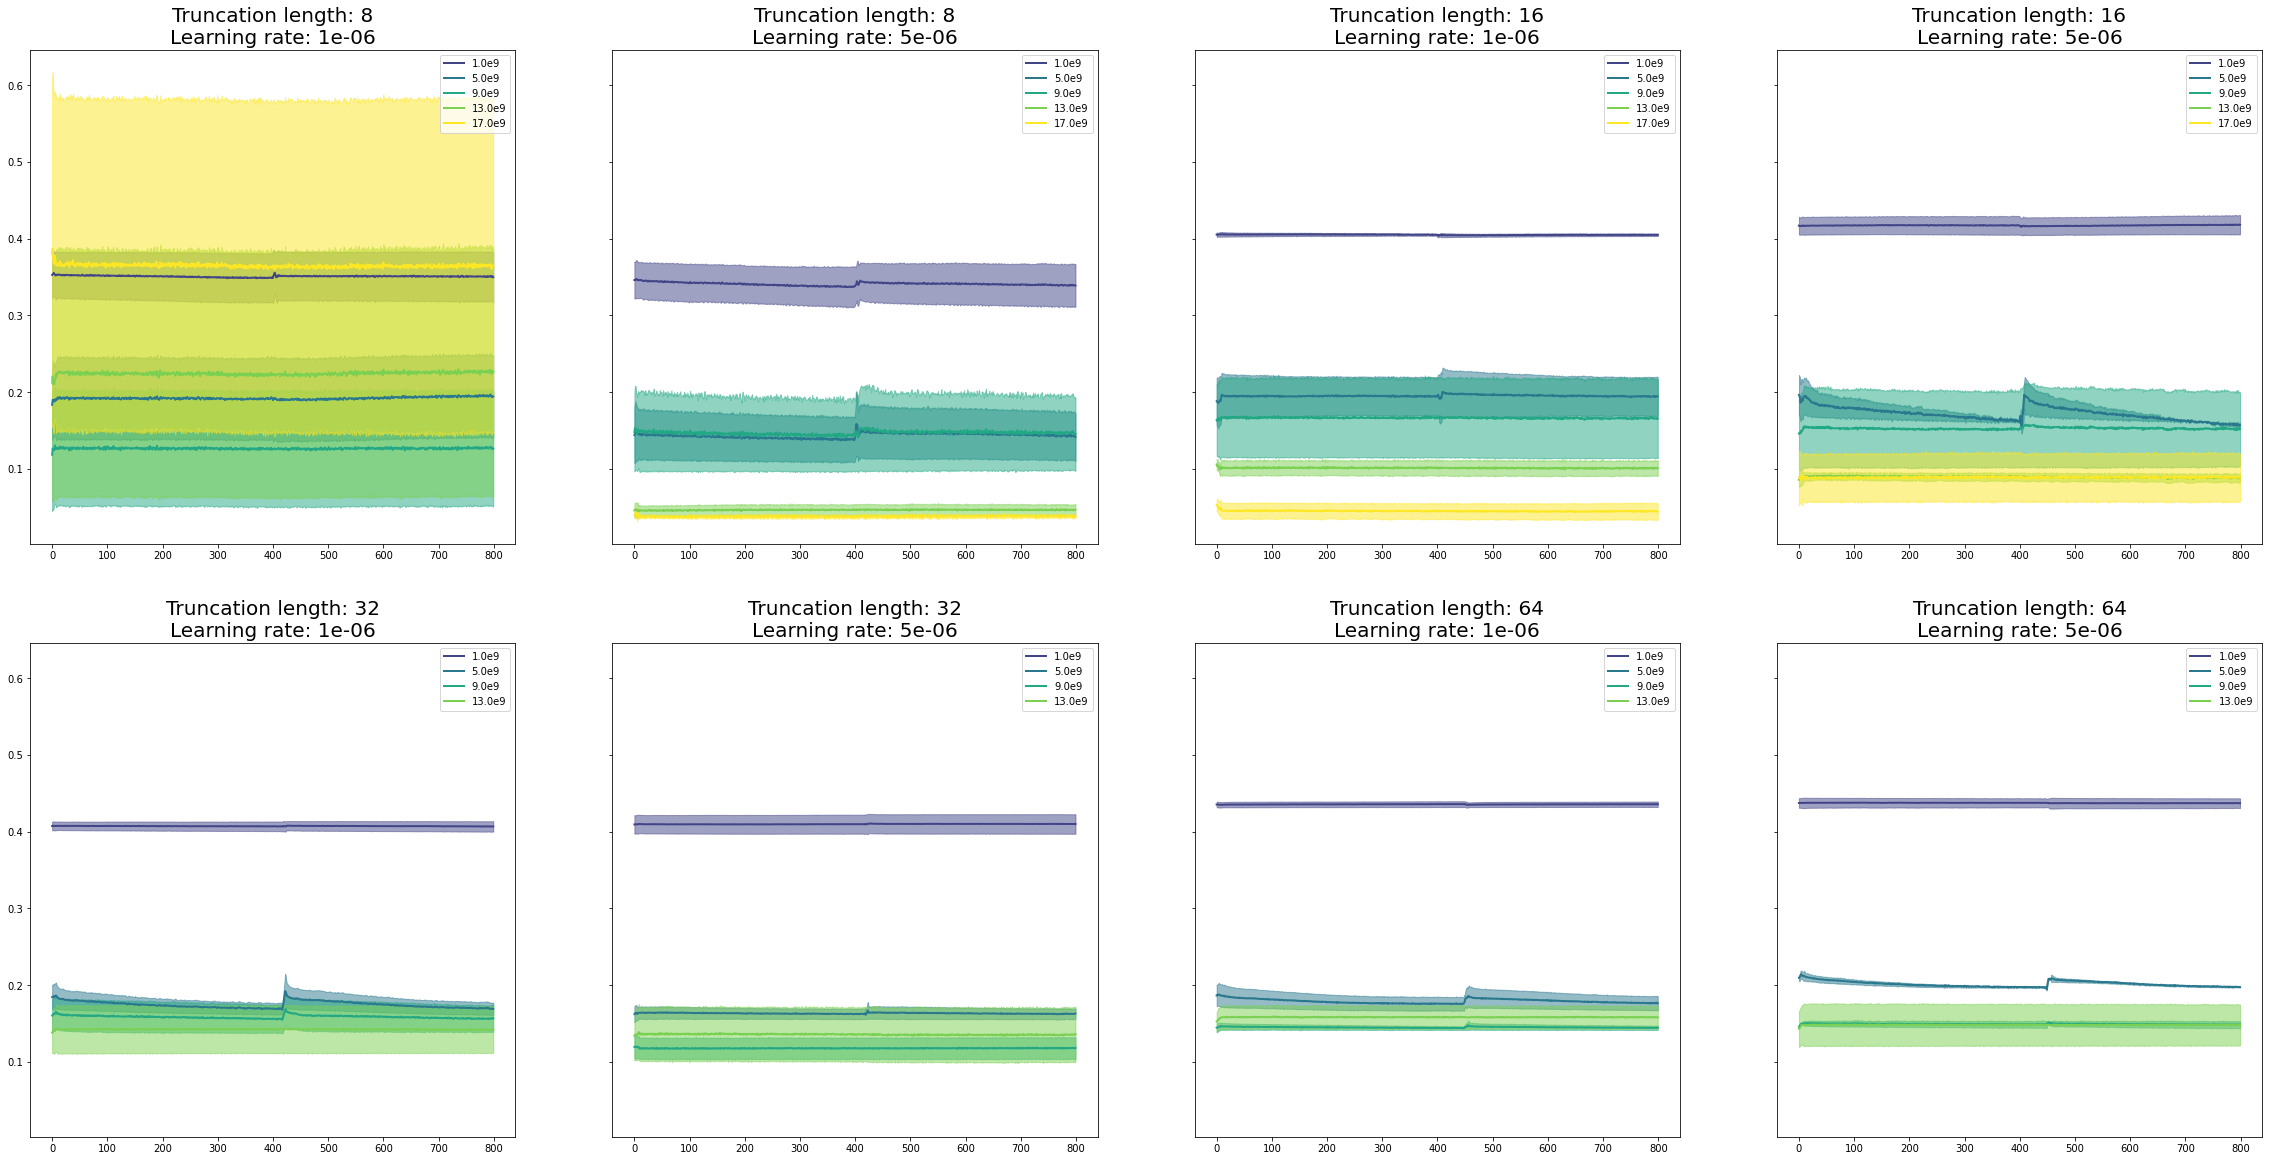

In [131]:
variants = eval_df.groupby(list(label_cols.keys())).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

sideX = 4
sideY = 2
fig, axes = plt.subplots(sideY, sideX, figsize=(10 * sideX, 10 * sideY), sharey=True)
axes = onp.array(axes)
window = 1

axes = axes.flatten()
for ax, row in zip(axes, variants.sort_values('HYPER_truncation_length').itertuples(index=False)):
    f = True
    for k, v in row._asdict().items():
        f = f & (eval_df[k] == v)
    
    eval_data = eval_df[f]
    ckpts = eval_data.HYPER_checkpoint_path.unique()
    ckpt_to_numeric = lambda x: int(re.findall(r'checkpoint\_([0-9]*)\.ckpt', x)[0])
    numeric_ckpts = list(map(ckpt_to_numeric, ckpts))
    ckpt_map = collections.defaultdict(list)
    for ckpt_no, ckpt in zip(numeric_ckpts, ckpts):
        ckpt_map[ckpt_no].append(ckpt)
    sorted_ckpt_nos = sorted(set(numeric_ckpts))
    chosen_ckpt_nos = sorted_ckpt_nos[::4]


    for i, ckpt_no in enumerate(chosen_ckpt_nos):
        ff = f & (df.HYPER_checkpoint_path.isin(ckpt_map[ckpt_no]))
        data = df[ff].reset_index()
    
        if len(data) == 0:
            continue

        smoothed = data.groupby('index')
        y = smoothed.mean()['ent_coef'].to_numpy()
        stderr = (smoothed.std()['ent_coef'].fillna(0.).to_numpy()
                    / onp.sqrt(len(eval_data.HYPER_seed.unique())))[:800]
        x = smoothed.mean().index
        out = pd.DataFrame({'x': x[:800], 'y': y[:800]})
        out.reset_index(inplace=True, drop=True)
        ax.plot(
            out.x, out.y,
            linewidth=2.0,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
            label=f'{onp.ceil(ckpt_no / 1e9)}e9'
        )
        ax.fill_between(
            out.x, out.y-stderr, out.y+stderr,
            alpha=0.5,
            color=plt.cm.get_cmap('viridis')((i+1) / 5),
        )
        params = row._asdict()
        title = f"Truncation length: {params['HYPER_truncation_length']}\n" \
                f"Learning rate: {params['HYPER_es_params_lrate_init']}"
        # ax.set_title('\n'.join(f"{label_cols[k]}: {v}" for k, v in row._asdict().items()), fontsize=20)
        ax.set_title(title, fontsize=20)
        ax.legend()
plt.savefig(f'images/checkpoints_ent_coef_es.pdf', bbox_inches='tight')
